# IC Photography Styles II

# Training Model and Cleaning Data

## Setting Up Necessary Things

In [1]:
# Jupyter Notebook Magic Command - Auto Reloading
%reload_ext autoreload
%autoreload 2

# Jupyter Notebook Magic Command - Inline Plotting
%matplotlib inline

# Batch Size
bs = 32

# Version
version = 0

In [2]:
# Ignore All Warnings
import warnings
warnings.filterwarnings("ignore")

## Necessary Imports

In [3]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *

## Collect and Split Data

In [4]:
# Path of the Data
data_path = "../data"

# Path of the PKL
pkl_path = "../dataloaders"

In [5]:
# Generate Data Container
pst_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,                          # returning a list of all images in that path recursively by default
    splitter=RandomSplitter(valid_pct=0.1, seed=42),    # getting 90-10 train-validation split
    get_y=parent_label,                                 # taking the folder name as labels
    item_tfms=Resize(128)                               # resizing to get the image of the same shape
)

In [6]:
# RandomResizeCrop and Image Augmentation
pst_dblock = pst_dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
pst_dls = pst_dblock.dataloaders(data_path, bs=bs)

# Save the dataloader as a PKL file
torch.save(pst_dls, f"{pkl_path}/pst_dataloader_v{version}.pkl")

In [7]:
# Load the dataloader of version
# pst_dls = torch.load(f"{pkl_path}/pst_dataloader_v{version}.pkl")

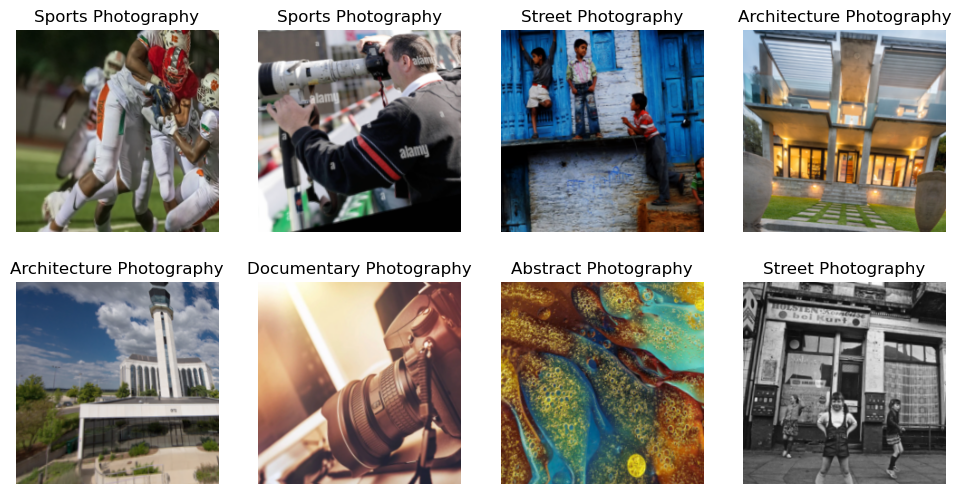

In [8]:
# Show train data
pst_dls.train.show_batch(max_n=8, nrows=2)

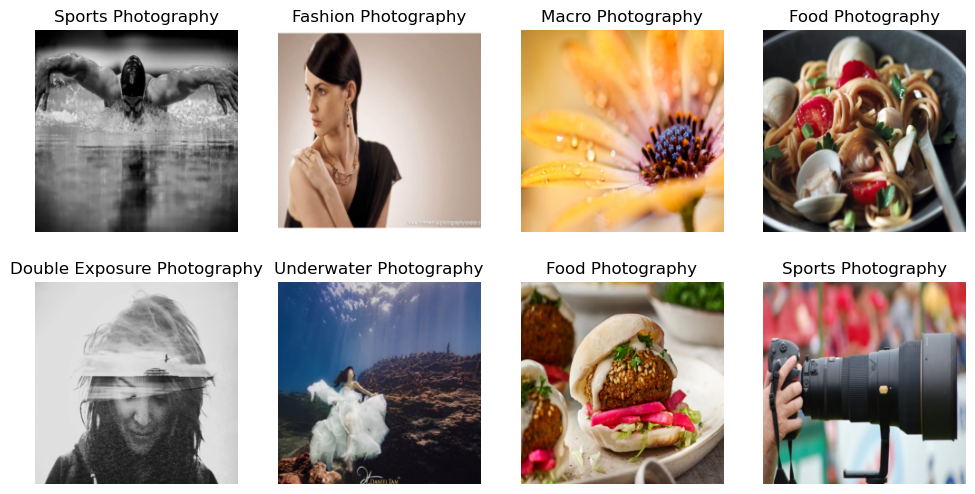

In [9]:
# Show valid data
pst_dls.valid.show_batch(max_n=8, nrows=2)

## Training and Data Cleaning

### Model Training

In [10]:
# Model Path
model_path = "../models"

if not os.path.exists(model_path):
    os.mkdir(model_path)

In [11]:
# Create Vision Learner of the Model
model = vision_learner(pst_dls, resnet34, metrics=[error_rate, accuracy])

In [12]:
# Load Previous Model
# model.load(f"pst_recognizer_v{version - 1}")

In [13]:
# Train Model
model.fine_tune(5)

In [14]:
# Save the model
model.save(f"pst_recognizer_v{version}")

Path('models/pst_recognizer_v0.pth')

In [15]:
# Load Current Model
# model.load(f"pst_recognizer_v{version}")

### Clean Data

In [16]:
# Create Confusion Matrix
interpretation = ClassificationInterpretation.from_learner(model)

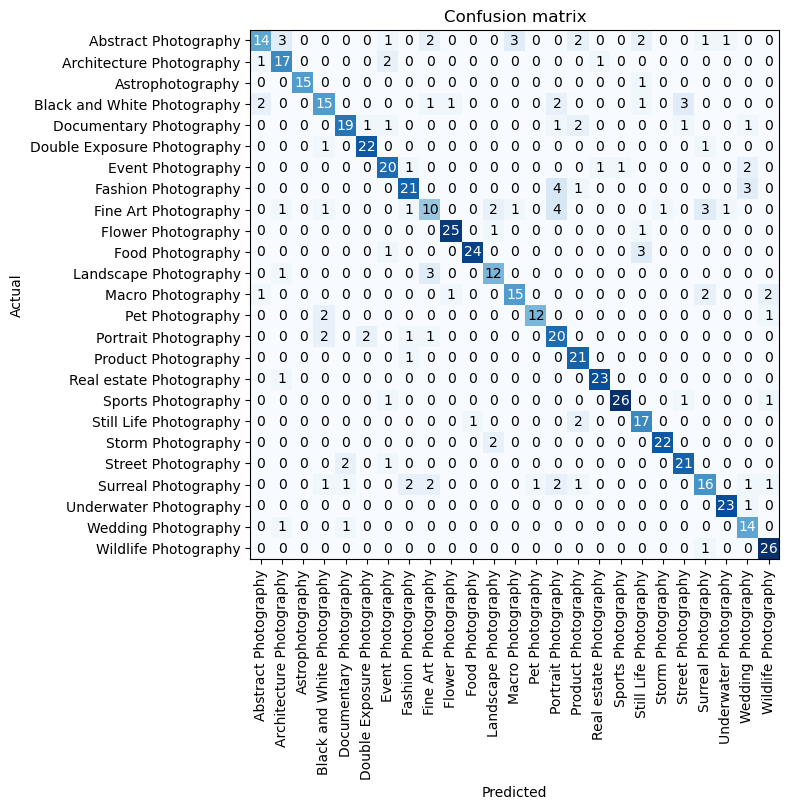

In [18]:
# Show Confusion Matrix in Plot
interpretation.plot_confusion_matrix(figsize=(8,8))

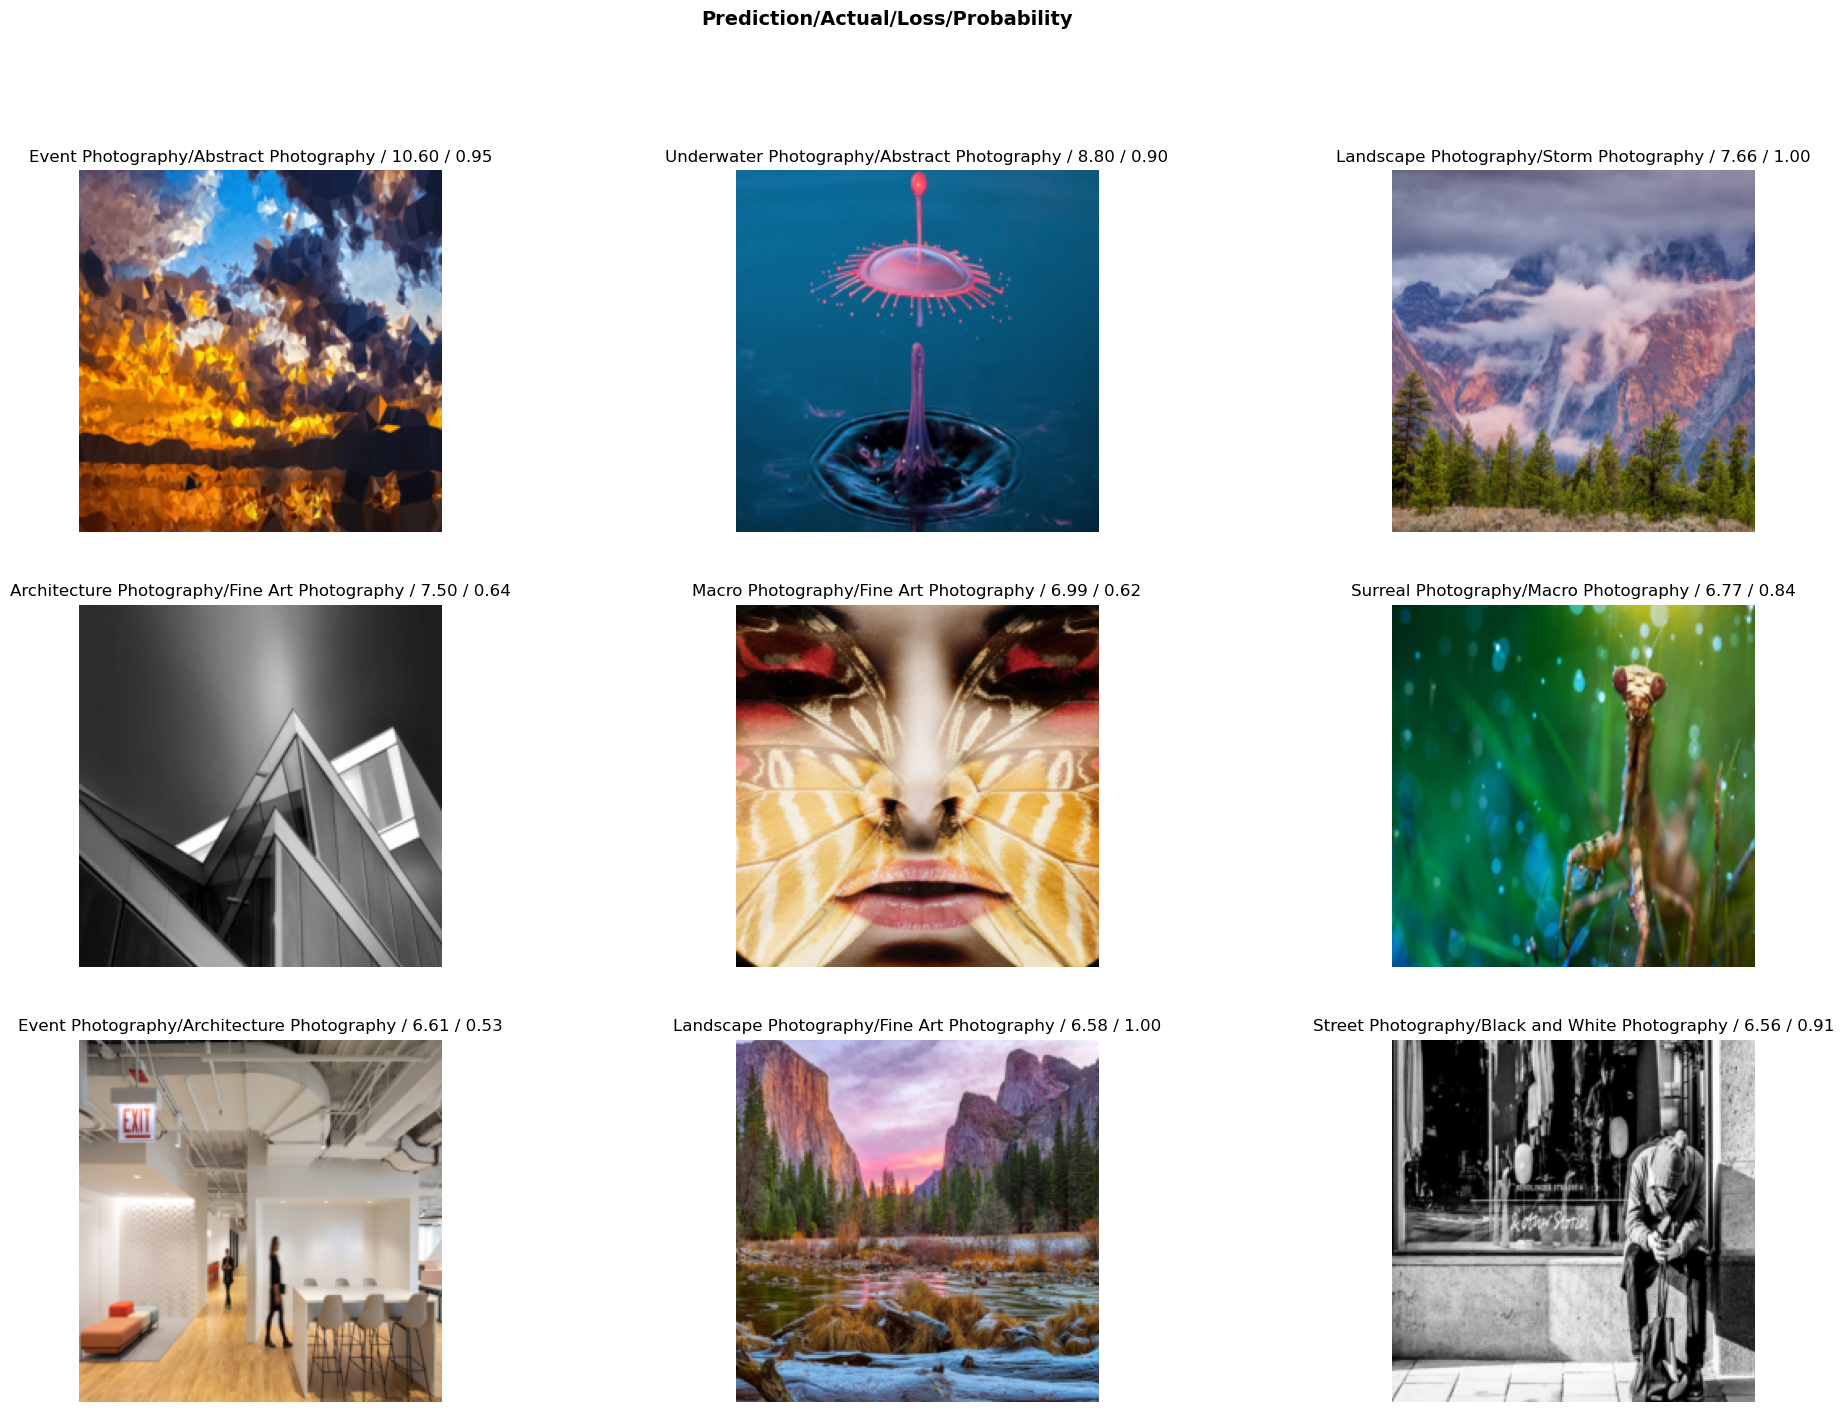

In [19]:
# Show Some Prediction Vs Actual
interpretation.plot_top_losses(9, nrows=3, figsize=(24, 16))

In [20]:
# Clean the Data
cleaner = ImageClassifierCleaner(model)
cleaner

In [21]:
# Delete data count
print("Total Deleted Data: ", len(cleaner.delete()))
cleaner.delete()

Total Deleted Data:  0


(#0) []

In [22]:
# Change data count
print("Total Changed Data: ", len(cleaner.change()))
cleaner.change()

Total Changed Data:  0


(#0) []

In [23]:
# Delete Irrelevant Data
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

# Change the directory
for idx, cdp in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), f"{data_path}/{cdp}")

print("Delete and Change Complete..!")

Delete and Change Complete..!


## Export The Model

In [24]:
# Export The Model
model.export(f"{model_path}/pst_recognizer_v{version}.pkl")